<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Анализ-и-подготовка-данных" data-toc-modified-id="Анализ-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Анализ и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нужно обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

**План выполнения проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Анализ и подготовка данных

Импортируем необходимые инструменты:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

### Анализ данных

Загрузим и проанализируем исходные данные:

In [2]:
df = pd.read_csv('toxic_comments.csv')

In [3]:
df.sample(5)

,text,toxic
138464,Is Zeno of Elea wrong?\nOf course Zeno just qu...,0
147620,apologise for being uncivil.,0
133063,"My bad, I haven't done this in a while! Thanks...",0
70553,this article could do with being tidied up by ...,0
40851,Discussion destroying CRAP topic \n\nIt seems ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


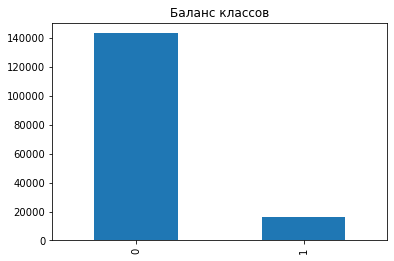

In [5]:
df['toxic'].value_counts()
df['toxic'].value_counts().plot(kind='bar', figsize=(6, 4))
plt.title('Баланс классов');

In [6]:
df.duplicated().sum()

0

**Вывод**

Исходные данные состоят из столбца-признака с текстом комментария и столбца-целевого признака с меткой о токсичности комментария. В данных отсутствуют пропуски и дубликаты, баланс классов не соблюдается - токсичных комментариев примерно в 9 раз меньше. 

### Подготовка данных

Выполним подготовку данных для модели, включающую токенизацию, лемматизацию, очистку от лишних символов и векторизацию.

Используем для этого функцию:

In [14]:
%%time
def preprocessing(sentence):
    lemmatized_output = " ".join([token.lemma_ for token in nlp(sentence)])
    processed_output = re.sub(r"[^a-zA-Z ]", " ", lemmatized_output).lower()
    return processed_output

nlp = spacy.load('en_core_web_sm')
df['processed_text'] = df['text'].apply(preprocessing)

Wall time: 53min 44s


Проверим получившийся результат:

In [15]:
df.head()

,text,toxic,processed_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usern...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i be s...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i be really not try to edit war it...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can not make any real suggestion ...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you rememb...


Исследуем различия токсичных и обычных комментариев, добавив признаки длины комментария, количества слов в нем и средней длины слов:

In [16]:
df['num_of_words'] = df['processed_text'].apply(lambda x: len(x.split()))
df['len_of_words'] = df['processed_text'].apply(lambda x: len(x))
df['mean_len_of_words'] = df['processed_text'].apply(lambda x: sum(len(y) for y in x.split()) / len(x.split()) 
                                                     if len(x.split()) != 0 else len(x)) 
df.sample(5)

,text,toxic,processed_text,num_of_words,len_of_words,mean_len_of_words
35538,What I find especially funny is that molecular...,0,what i find especially funny be that molecular...,74,477,5.243243
123363,"however , i dispute vandalism claims, it was a...",0,however i dispute vandalism claim it be a ...,15,104,4.666667
18448,REDIRECT Talk:University of the Philippines Ce...,0,redirect talk university of the philippines ...,8,58,6.125000
12075,"Yes, Claire apparently had a problem with how ...",0,yes claire apparently have a problem with ho...,30,177,3.933333
61878,"""\n\nHow is """"And You Will Know Us by the Trai...",0,how be and you will know us by the tr...,26,154,4.000000


In [17]:
display(df[df['toxic'] == 1].describe())
df[df['toxic'] == 0].describe()

,toxic,num_of_words,len_of_words,mean_len_of_words
count,16225.0,16225.000000,16225.000000,16225.000000
mean,1.0,54.273652,310.215840,4.316973
std,0.0,110.268176,643.891686,14.934271
min,1.0,2.000000,8.000000,1.000000
25%,1.0,11.000000,63.000000,3.620000
50%,1.0,23.000000,131.000000,3.972477
75%,1.0,51.000000,286.000000,4.333333
max,1.0,1403.000000,9912.000000,1240.000000


,toxic,num_of_words,len_of_words,mean_len_of_words
count,143346.0,143346.000000,143346.000000,143346.000000
mean,0.0,69.784424,409.204519,4.306887
std,0.0,99.778302,592.880780,2.036400
min,0.0,0.000000,6.000000,1.250000
25%,0.0,18.000000,104.000000,3.916667
50%,0.0,38.000000,219.000000,4.250000
75%,0.0,79.000000,457.000000,4.594845
max,0.0,1250.000000,7831.000000,708.571429


В токсичных комментариях в среднем меньше слов, а сами комментарии короче, средняя длина слов примерно одинакова. 

Разделим данные на тренировочную и тестовую части:

In [18]:
features = df['processed_text']
target = df['toxic']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=target)

features_grid = features_train.copy()
target_grid = target_train.copy()
features_train.shape, features_test.shape

((119678,), (39893,))

**Вывод**

Данные токенизированы и лемматизированы, очищены от лишних символов, подготовлены к векторизации и обучению.

## Обучение

Найдем лучшие параметры для совокупности `TfidfVectorizer()` и `LogisticRegression()`:

In [19]:
%%time
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

lr_pipe = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)), ('clf', LogisticRegression(random_state=1703))])
params = {'vect__max_df' : [0.5, 1],
          'vect__max_features': (None, 1000, 5000),
          'clf__C': [20, 40],
          'clf__max_iter' : [500, 1000]}
lr_grid = GridSearchCV(estimator=lr_pipe, param_grid=params, cv=3, scoring='f1')
lr_grid.fit(features_grid, target_grid)

scores = []
scores.append(lr_grid.best_score_)
lr_grid.best_params_, lr_grid.best_score_

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ekate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wall time: 11min 56s


({'clf__C': 20,
  'clf__max_iter': 500,
  'vect__max_df': 0.5,
  'vect__max_features': None},
 0.7693408570207912)

Найдем лучшие параметры для совокупности `TfidfVectorizer()` и `DecisionTreeClassifier()`:

In [20]:
%%time

dtc_pipe = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)), ('clf', DecisionTreeClassifier(random_state=1703))])
params = {'vect__max_df' : [0.5, 0.75],
          'vect__max_features': (None, 500),
          'clf__max_depth': [3, 7, 10]}
dtc_grid = GridSearchCV(estimator=dtc_pipe, param_grid=params, cv=3, scoring='f1')
dtc_grid.fit(features_grid, target_grid)

scores.append(dtc_grid.best_score_)
dtc_grid.best_params_, dtc_grid.best_score_

Wall time: 5min 20s


({'clf__max_depth': 10, 'vect__max_df': 0.5, 'vect__max_features': None},
 0.596594900136357)

Найдем предсказания с помощью `CatBoostClassifier()`, предварительно векторизуем данные:

In [21]:
vectorizer = TfidfVectorizer(max_df=0.5, stop_words=stopwords)
features_grid_train = vectorizer.fit_transform(features_train)
features_grid_test = vectorizer.transform(features_test)

In [22]:
%%time
cbc_model = CatBoostClassifier(verbose=200, random_state=1703)
cbc_model.fit(features_grid_train, target_train)
cbc_pred = cbc_model.predict(features_grid_test)
scores.append(f1_score(target_test, cbc_pred))

Learning rate set to 0.079478
0:	learn: 0.6095716	total: 1.15s	remaining: 19m 13s
200:	learn: 0.1506600	total: 2m 54s	remaining: 11m 32s
400:	learn: 0.1297076	total: 5m 45s	remaining: 8m 35s
600:	learn: 0.1185357	total: 8m 39s	remaining: 5m 45s
800:	learn: 0.1103563	total: 11m 40s	remaining: 2m 53s
999:	learn: 0.1039706	total: 14m 39s	remaining: 0us
Wall time: 14min 48s


Проанализируем получившиеся результаты:

,F1
LogisticRegressor,0.769341
DesicionTreeClassifier,0.596595
CatBoostClassifier,0.759147


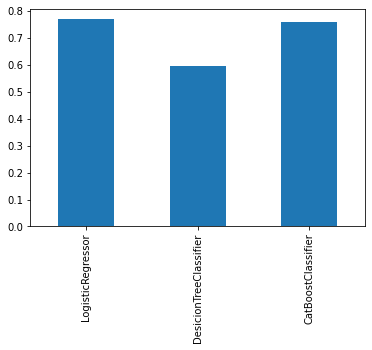

In [23]:
result = pd.DataFrame(scores, columns=['F1'],
                        index=['LogisticRegressor', 'DesicionTreeClassifier', 'CatBoostClassifier'])
result['F1'].plot(kind='bar', figsize=(6, 4))
display(result)

**Вывод**

Модели обучены, получено нужное значение метрики F1, лучших результатов достигла модель логистической регрессии, выберем ее в качестве финальной.

## Выводы

Проведем финальное тестирование модели логистической регрессии:

In [24]:
final_predictions = lr_grid.best_estimator_.predict(features_test)
print('Итоговый результат: ', f1_score(target_test, final_predictions))

Итоговый результат:  0.7829171783326512


Лучший результат классификации комментариев показала модель логистической регрессии с F1 равным 0,785 на тестовой выборке, кроме того, эта модель обучается и предсказывает гораздо быстрее CatBoostClassifier. Выяснилось, что токсичные комментарии отличаются меньшей длиной и меньшим количеством слов. 

В ходе работы выполнено следующее:
* проанализированы исходные данные, выявлено следующее: в данных отсутствуют пропуски и дубликаты, баланс классов не соблюдается - токсичных комментариев примерно в 9 раз меньше. 
* выявлены различия токсичных и нейтральных комментариваев: в токсичных комментариях в среднем меньше слов, а сами комментарии короче;
* выполнена подготовка данных для модели, включающую в себя:
    * токенизацию; 
    * лемматизацию;
    * очистку от лишних символов
    * векторизацию;
* подобраны гиперпараметры и обучены следующие модели:
    * модель логистической регрессии с метрикой F1 на валидационной выборке, равной 0,77;
    * модель решающего дерева с F1 = 0,598;
    * модель CatBoostClassifier с F1 = 0,76.
    
Лучший результат классификации комментариев показала модель логистической регрессии с F1 на тестовой выборке равным **0,785** на тестовой выборке, кроме того, эта модель обучается и предсказывает гораздо быстрее CatBoostClassifier.